<a href="https://colab.research.google.com/github/sipocz/Zindi_plastic/blob/main/Image_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [87]:
import ee
import geemap
import PIL
import pandas
from google.colab import drive

In [88]:
_DEBUG_=False
_PROJECT_BASE_='/content/drive/MyDrive/Zindi_Plastic_images/'
_IMAGES_='images'
_TEST_IMAGES_='test_images'

_ORIG_='orig'


In [89]:
ee.Authenticate()
ee.Initialize(project='zindiplasticproject')
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [90]:
def add_time(image):
  return image.addBands(image.getNumber('system:time_start'))

In [91]:
def conditional(image):
  return ee.Algorithms.If(
      ee.Number(image.get('SUN_ELEVATION')).gt(40), image, ee.Image(0)
  )


In [92]:
def gamma_correct(gamma, path):
    """

    Args:
      gamma: selected gamma value
      path: the path of the image

    Returns: gamma corrected image

    """
    im = PIL.Image.open(path)
    gamma1 = gamma
    row = im.size[0]
    col = im.size[1]
    result_img1 = PIL.Image.new(mode="RGB", size=(row, col), color=0)
    for x in range(row):
        for y in range(col):
            r = pow(im.getpixel((x, y))[0] / 255, (1 / gamma1)) * 255
            g = pow(im.getpixel((x, y))[1] / 255, (1 / gamma1)) * 255
            b = pow(im.getpixel((x, y))[2] / 255, (1 / gamma1)) * 255
            # add
            color = (int(r), int(g), int(b))
            result_img1.putpixel((x, y), color)
    #show
    return result_img1

In [108]:
def image_download(index=int,longitude=float,latitude=float,place=str,sat=None,band=None,sdate="2024-04-15",edate="2024-04-17"):
    from math import gamma
    import geemap
    import ee

    # Google Earth Engine inicializálása
    ee.Initialize()

    if sat==None:
        sat='COPERNICUS/S2_SR_HARMONIZED'
    if band==None:
        band=['B11','B12','B8']

    # 1000 méteres körzet létrehozása Budapest középpontjában
    point = ee.Geometry.Point([longitude, latitude])
    buffer = point.buffer(10).bounds()  # 1000 méteres buffer

    # Sentinel-2 műholdkép lekérése nappali időszakban
    collection = ee.ImageCollection(sat) \
        .filterBounds(buffer) \
        .filterDate(sdate, edate) \
        .sort('CLOUDY_PIXEL_PERCENTAGE')  # Legkevésbé felhős kép kiválasztása
    first_image = collection.first()  # Az első legkevésbé felhős kép

    # Ellenőrizd, hogy az első kép érvényes
    if first_image is None:
        raise ValueError("Nem találtunk érvényes képet a megadott időszakban.")

    # Kép RGB sávok kiválasztása
    image = first_image.select(band)  # Red, Green, Blue
    import matplotlib.pyplot as plt

    aoi=ee.Geometry.Rectangle(longitude-0.005,latitude-0.005,longitude+0.005,latitude+0.005 )


    rgb_img = geemap.ee_to_numpy(image,region=aoi)
    if _DEBUG_==True:
        print(rgb_img.shape)

    max_p=15448 #rgb_img[:,:,2].max()

    rgb_img_test = (255 * ((rgb_img[:, :, 0:3] ) / max_p)).astype("uint8")

    if _DEBUG_==True:
        print(rgb_img[:,:,2].max())


    img=PIL.Image.fromarray(rgb_img_test)

    img=img.resize((192,192))
    return img


In [94]:
_DEBUG_=True

In [105]:
pil_image=image_download(20,37.05635887,0.053674338,"Kenya",sat="COPERNICUS/S2_SR_HARMONIZED",band=['B7','B8','B8A'],sdate="2024-04-14",edate="2024-05-04")

(56, 56, 3)
15051


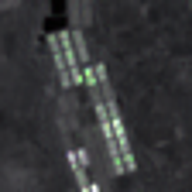

In [106]:
pil_image

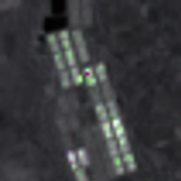

In [97]:
pil_image.crop((0,0,181,181))


In [98]:
image_download(20,37.05635887,0.053674338,"Kenya")

Exception: Image.select: Parameter 'input' is required.

In [99]:

df_kenya=pandas.read_csv(_PROJECT_BASE_+_ORIG_+"/Kenya_training.csv")


In [100]:
df_kenya.head()

,ID,lon,lat,blue_p50,green_p50,nir_p50,nira_p50,re1_p50,re2_p50,re3_p50,red_p50,swir1_p50,swir2_p50,VV_p50,VH_p50,TARGET
0,1,37.059054,0.046039,2731.0,3035.0,5418.0,5306.5,2958.0,4610.5,5099.5,2994.0,4108.5,3187.5,-6.861458,-12.162713,1
1,2,37.059503,0.047296,2921.0,3329.0,5834.0,6472.0,4144.5,5782.0,6302.0,3344.0,5269.0,4471.5,-8.082717,-14.619608,1
2,3,37.057527,0.047656,3828.0,4163.0,6420.0,7890.5,5408.5,6695.5,7302.0,4380.0,6905.0,6905.5,-7.767043,-14.880353,1
3,4,37.057976,0.047925,2556.0,2839.0,4822.0,5276.5,3201.0,4643.0,5069.5,2787.0,3832.0,2867.5,-7.773118,-15.587653,1
4,5,37.056359,0.048554,3790.0,4009.0,6476.0,6199.5,4285.0,5711.0,6079.5,3939.0,4892.5,3702.5,-6.104467,-15.431915,1


In [101]:
def image_generation(df,image_id):
    for i,row in df.iterrows():
        image=image_download(row.ID,row.lon,row.lat,image_id,sat=_sat_,band=_band_,sdate="2024-04-14",edate="2024-05-04")
        image.save(_PROJECT_BASE_+_IMAGES_+"/"+str(int(row.ID))+'_'+str(int(row.TARGET))+"_"+image_id+".jpg")
        print(str(i).rjust(3,'0'),end=".")
        if i % 20==0:
            print("*")

In [102]:
_sat_=None
_band_=None
_image_id_="kenya"

In [109]:
image_generation(df_kenya,_image_id_)

(57, 56, 3)
15448
000.*
(57, 57, 3)
15448
001.(57, 57, 3)
15448
002.(56, 56, 3)
15448
003.(57, 56, 3)
15448
004.(56, 56, 3)
15448
005.(57, 57, 3)
15448
006.(57, 56, 3)
15448
007.(57, 56, 3)
15448
008.(56, 56, 3)
15448
009.(57, 56, 3)
15448
010.(57, 57, 3)
15448
011.(56, 56, 3)
15448
012.(57, 56, 3)
15448
013.(56, 57, 3)
15448
014.(57, 57, 3)
15448
015.(56, 57, 3)
15448
016.(56, 56, 3)
15448
017.(56, 57, 3)
15448
018.(56, 56, 3)
15448
019.(56, 56, 3)
15416
020.*
(56, 57, 3)
15416
021.(56, 56, 3)
15416
022.(56, 56, 3)
15416
023.(56, 56, 3)
15416
024.(56, 56, 3)
15416
025.(56, 57, 3)
15416
026.(57, 57, 3)
4728
027.(56, 56, 3)
5033
028.(56, 57, 3)
5033
029.(56, 57, 3)
5033
030.(57, 57, 3)
5033
031.(57, 56, 3)
5033
032.(56, 57, 3)
5033
033.(56, 57, 3)
5033
034.(56, 56, 3)
5033
035.(56, 56, 3)
5033
036.(56, 56, 3)
5033
037.(56, 56, 3)
5033
038.(56, 57, 3)
5033
039.(56, 57, 3)
4514
040.*
(56, 56, 3)
4514
041.(56, 57, 3)
4514
042.(56, 56, 3)
5059
043.(56, 56, 3)
5089
044.(56, 56, 3)
4429
045.(

In [110]:
df_spain=pandas.read_csv(_PROJECT_BASE_+_ORIG_+"/Spain_training.csv")
_image_id_="spain"

In [111]:
image_generation(df_spain,_image_id_)

(56, 46, 3)
7160
000.*
(56, 45, 3)
7484
001.(56, 46, 3)
7922
002.(57, 46, 3)
6894
003.(57, 46, 3)
6073
004.(57, 46, 3)
7016
005.(57, 46, 3)
6949
006.(57, 46, 3)
7265
007.(56, 46, 3)
6478
008.(57, 46, 3)
6716
009.(57, 45, 3)
8304
010.(57, 46, 3)
5880
011.(56, 46, 3)
6736
012.(56, 45, 3)
6736
013.(57, 45, 3)
6342
014.(56, 45, 3)
6325
015.(57, 46, 3)
6590
016.(57, 47, 3)
5737
017.(56, 46, 3)
6691
018.(57, 47, 3)
5823
019.(56, 46, 3)
9494
020.*
(56, 46, 3)
6344
021.(56, 46, 3)
7438
022.(56, 46, 3)
7438
023.(57, 45, 3)
7343
024.(57, 45, 3)
8302
025.(56, 46, 3)
8302
026.(57, 46, 3)
9382
027.(56, 46, 3)
9742
028.(57, 46, 3)
10136
029.(57, 46, 3)
7430
030.(56, 46, 3)
6997
031.(57, 46, 3)
7426
032.(57, 46, 3)
7546
033.(57, 46, 3)
7660
034.(56, 46, 3)
7530
035.(57, 46, 3)
7412
036.(57, 45, 3)
7150
037.(57, 46, 3)
7276
038.(57, 46, 3)
7310
039.(56, 46, 3)
7864
040.*
(57, 46, 3)
6846
041.(57, 46, 3)
7004
042.(56, 46, 3)
6768
043.(57, 45, 3)
7408
044.(57, 46, 3)
6962
045.(56, 46, 3)
6724
046.(57, 4

In [112]:
df_vnm=pandas.read_csv(_PROJECT_BASE_+_ORIG_+"/VNM_training.csv")
_image_id_="vnm"

In [113]:
df_vnm.head()

,ID,Lon,Lat,blue_p50,green_p50,nir_p50,nira_p50,re1_p50,re2_p50,re3_p50,red_p50,swir1_p50,swir2_p50,VV_p50,VH_p50,TARGET
0,1,108.307403,11.706890,1772.5,2081.5,4393.0,4322.0,2542.0,3974.5,4315.0,1901.5,2929.5,2324.0,-5.506588,-16.577070,1
1,2,108.363279,11.778036,2178.0,2347.0,3427.0,3712.0,2658.5,3358.0,3628.5,2313.0,3122.0,2729.5,-7.798610,-14.007271,1
2,3,108.193946,11.689462,2927.0,3107.0,4365.0,4624.5,3378.0,4221.5,4508.5,3082.0,3921.0,3190.0,-7.652615,-14.319975,1
3,4,108.200324,11.691618,2175.0,2312.0,3472.5,3613.5,2569.5,3332.0,3558.5,2244.0,3132.5,2610.0,-9.530750,-16.471949,1
4,5,108.203109,11.694313,2125.0,2235.0,2612.0,2960.0,2548.5,2801.0,2908.0,2320.0,2915.0,2685.5,-9.733130,-18.106146,1


In [114]:
df_vnm['lon']=df_vnm["Lon"]
df_vnm['lat']=df_vnm["Lat"]

In [115]:
image_generation(df_vnm,_image_id_)

(57, 57, 3)
6601
000.*
(57, 56, 3)
6703
001.(57, 57, 3)
5053
002.(57, 56, 3)
5130
003.(57, 56, 3)
5387
004.(57, 56, 3)
4538
005.(57, 56, 3)
3998
006.(57, 56, 3)
4159
007.(57, 56, 3)
5589
008.(57, 56, 3)
4159
009.(57, 56, 3)
4295
010.(57, 56, 3)
4219
011.(57, 56, 3)
4295
012.(57, 56, 3)
4295
013.(57, 56, 3)
6333
014.(57, 56, 3)
6378
015.(57, 56, 3)
5593
016.(57, 56, 3)
6333
017.(57, 56, 3)
6378
018.(57, 56, 3)
5935
019.(57, 57, 3)
5236
020.*
(57, 56, 3)
5428
021.(57, 57, 3)
5399
022.(57, 56, 3)
5884
023.(57, 56, 3)
5028
024.(57, 57, 3)
4478
025.(57, 56, 3)
4797
026.(57, 57, 3)
5028
027.(57, 57, 3)
6030
028.(57, 56, 3)
6030
029.(58, 56, 3)
6030
030.(57, 56, 3)
6030
031.(57, 57, 3)
6030
032.(57, 56, 3)
5125
033.(57, 56, 3)
5807
034.(57, 57, 3)
5152
035.(57, 57, 3)
5152
036.(57, 56, 3)
6030
037.(57, 56, 3)
5152
038.(57, 56, 3)
5152
039.(57, 57, 3)
6030
040.*
(57, 56, 3)
5713
041.(57, 57, 3)
5152
042.(57, 56, 3)
5807
043.(58, 56, 3)
6030
044.(57, 56, 3)
5656
045.(57, 56, 3)
5807
046.(57, 57

In [116]:
df_vnm.head()

,ID,Lon,Lat,blue_p50,green_p50,nir_p50,nira_p50,re1_p50,re2_p50,re3_p50,red_p50,swir1_p50,swir2_p50,VV_p50,VH_p50,TARGET,lon,lat
0,1,108.307403,11.706890,1772.5,2081.5,4393.0,4322.0,2542.0,3974.5,4315.0,1901.5,2929.5,2324.0,-5.506588,-16.577070,1,108.307403,11.706890
1,2,108.363279,11.778036,2178.0,2347.0,3427.0,3712.0,2658.5,3358.0,3628.5,2313.0,3122.0,2729.5,-7.798610,-14.007271,1,108.363279,11.778036
2,3,108.193946,11.689462,2927.0,3107.0,4365.0,4624.5,3378.0,4221.5,4508.5,3082.0,3921.0,3190.0,-7.652615,-14.319975,1,108.193946,11.689462
3,4,108.200324,11.691618,2175.0,2312.0,3472.5,3613.5,2569.5,3332.0,3558.5,2244.0,3132.5,2610.0,-9.530750,-16.471949,1,108.200324,11.691618
4,5,108.203109,11.694313,2125.0,2235.0,2612.0,2960.0,2548.5,2801.0,2908.0,2320.0,2915.0,2685.5,-9.733130,-18.106146,1,108.203109,11.694313


In [117]:
df_spain_test=pandas.read_csv(_PROJECT_BASE_+_ORIG_+"/Spain_validation.csv")
_image_id_="_spain_testing"
_sat_=None
_band_=None
df_spain_test["TARGET"]=0

In [118]:
image_generation(df_spain_test,_image_id_)


(57, 46, 3)
7582
000.*
(56, 46, 3)
7484
001.(57, 45, 3)
7462
002.(57, 46, 3)
7016
003.(57, 46, 3)
6573
004.(57, 47, 3)
6395
005.(57, 46, 3)
6395
006.(57, 46, 3)
7054
007.(56, 46, 3)
6016
008.(57, 46, 3)
6736
009.(57, 46, 3)
6736
010.(57, 46, 3)
6384
011.(56, 46, 3)
5921
012.(57, 45, 3)
6731
013.(57, 45, 3)
6731
014.(56, 46, 3)
6645
015.(57, 46, 3)
5873
016.(57, 46, 3)
6691
017.(57, 46, 3)
5823
018.(56, 46, 3)
7089
019.(57, 46, 3)
6388
020.*
(57, 46, 3)
6504
021.(56, 46, 3)
7438
022.(57, 46, 3)
7438
023.(56, 45, 3)
8902
024.(57, 46, 3)
7343
025.(56, 46, 3)
7912
026.(57, 46, 3)
8190
027.(57, 46, 3)
8302
028.(57, 46, 3)
8976
029.(56, 45, 3)
9330
030.(57, 46, 3)
6941
031.(57, 46, 3)
7396
032.(57, 46, 3)
7548
033.(57, 46, 3)
7224
034.(57, 46, 3)
7840
035.(57, 46, 3)
7366
036.(57, 46, 3)
8066
037.(57, 45, 3)
7546
038.(56, 46, 3)
8274
039.(56, 45, 3)
7342
040.*
(56, 46, 3)
7582
041.(57, 45, 3)
7450
042.(57, 46, 3)
6661
043.(57, 45, 3)
7664
044.(57, 46, 3)
7394
045.(56, 46, 3)
7484
046.(56, 46

In [119]:
df_vnm_test=pandas.read_csv(_PROJECT_BASE_+_ORIG_+"/VNM_testing.csv")
_image_id_="_vnm_testing"
_sat_=None
_band_=None
df_vnm_test["TARGET"]=0
df_vnm_test["lon"]=df_vnm_test["Lon"]
df_vnm_test["lat"]=df_vnm_test["Lat"]

In [120]:
df_vnm_test.head()


,ID,Lon,Lat,blue_p50,green_p50,nir_p50,nira_p50,re1_p50,re2_p50,re3_p50,red_p50,swir1_p50,swir2_p50,VV_p50,VH_p50,TARGET,lon,lat
0,1,108.406667,11.699973,2284.0,2429.0,2857.0,3314.5,2690.5,3043.5,3165.0,2461.0,3385.5,2848.0,-9.688691,-17.492636,0,108.406667,11.699973
1,2,108.364087,11.780641,2606.0,2743.0,3708.0,4164.0,3226.5,3826.5,4080.5,2819.0,3978.5,3402.0,-8.679594,-16.148212,0,108.364087,11.780641
2,3,108.201133,11.690091,1965.0,2174.0,3713.0,3767.0,2475.5,3473.5,3750.5,2050.0,2870.5,2309.0,-7.793950,-14.815912,0,108.201133,11.690091
3,4,108.196731,11.692157,2010.0,2051.0,2401.0,2510.0,2234.0,2448.0,2532.0,2106.0,2476.5,2137.0,-9.485932,-15.773308,0,108.196731,11.692157
4,5,108.197809,11.695032,2084.0,2253.0,3148.0,3371.0,2628.0,3212.5,3369.0,2301.0,3226.0,2874.0,-7.751073,-16.848070,0,108.197809,11.695032


In [121]:
image_generation(df_vnm_test,_image_id_)

(57, 56, 3)
4924
000.*
(57, 56, 3)
6703
001.(57, 56, 3)
5130
002.(57, 57, 3)
5130
003.(57, 56, 3)
5130
004.(57, 56, 3)
3998
005.(57, 56, 3)
3811
006.(57, 56, 3)
4159
007.(57, 56, 3)
4205
008.(57, 56, 3)
5589
009.(57, 56, 3)
5589
010.(57, 56, 3)
4219
011.(57, 57, 3)
4295
012.(57, 56, 3)
4766
013.(57, 56, 3)
6333
014.(57, 57, 3)
5593
015.(57, 56, 3)
6333
016.(57, 56, 3)
6378
017.(57, 56, 3)
11514
018.(57, 57, 3)
4074
019.(57, 56, 3)
5236
020.*
(57, 56, 3)
5623
021.(57, 56, 3)
5266
022.(57, 56, 3)
4627
023.(57, 56, 3)
5724
024.(57, 56, 3)
5360
025.(58, 57, 3)
4741
026.(57, 56, 3)
6030
027.(57, 56, 3)
6030
028.(57, 56, 3)
6030
029.(57, 56, 3)
4623
030.(57, 57, 3)
5152
031.(57, 56, 3)
5152
032.(57, 56, 3)
4623
033.(57, 57, 3)
5152
034.(57, 56, 3)
6030
035.(57, 56, 3)
6030
036.(57, 57, 3)
6030
037.(57, 57, 3)
6030
038.(57, 56, 3)
5152
039.(57, 57, 3)
5152
040.*
(57, 57, 3)
5713
041.(57, 56, 3)
5656
042.(57, 56, 3)
6030
043.(57, 57, 3)
6030
044.(57, 56, 3)
6030
045.(57, 57, 3)
5656
046.(57, 5

In [122]:
df_kenya_test=pandas.read_csv(_PROJECT_BASE_+_ORIG_+"/Kenya_testing.csv")
_image_id_="_kenya_testing"
_sat_=None
_band_=None
df_kenya_test["TARGET"]=0


In [123]:
image_generation(df_kenya_test,_image_id_)

(56, 56, 3)
15448
000.*
(56, 56, 3)
15448
001.(56, 56, 3)
15448
002.(56, 57, 3)
15448
003.(57, 57, 3)
15448
004.(57, 57, 3)
15448
005.(57, 57, 3)
15448
006.(57, 57, 3)
15448
007.(57, 57, 3)
15448
008.(56, 56, 3)
15448
009.(56, 56, 3)
15448
010.(57, 56, 3)
15448
011.(56, 56, 3)
15448
012.(57, 56, 3)
15448
013.(56, 57, 3)
15448
014.(57, 56, 3)
15448
015.(56, 57, 3)
15448
016.(56, 57, 3)
15448
017.(56, 56, 3)
15448
018.(56, 57, 3)
15448
019.(56, 57, 3)
15416
020.*
(56, 56, 3)
15416
021.(56, 57, 3)
15416
022.(56, 56, 3)
15416
023.(56, 56, 3)
15416
024.(56, 57, 3)
15416
025.(56, 57, 3)
4758
026.(57, 56, 3)
5033
027.(56, 57, 3)
5033
028.(56, 56, 3)
5033
029.(57, 56, 3)
4728
030.(56, 56, 3)
5033
031.(56, 57, 3)
5033
032.(56, 56, 3)
5033
033.(56, 57, 3)
5033
034.(56, 56, 3)
5033
035.(56, 56, 3)
5219
036.(56, 57, 3)
5227
037.(56, 57, 3)
5033
038.(56, 57, 3)
4514
039.(56, 56, 3)
4514
040.*
(56, 57, 3)
4514
041.(56, 57, 3)
4429
042.(56, 56, 3)
4429
043.(57, 57, 3)
4429
044.(56, 57, 3)
5563
045.(5

In [124]:

# _sat_="LANDSAT/LC08/C02/T1_L2"
# _band_=['SR_B7','SR_B3','SR_B2']
# _image_id_="_kenya_landsat"

In [125]:
# image_generation(df_kenya,_image_id_)

In [126]:
def format_image(image_dir):
    image = tf.read_file(image_dir)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize_image_with_pad(image, 256, 256, align_corners=True)
    return image

In [127]:
test_images_dir=_PROJECT_BASE_+_TEST_IMAGES_
images_dir=_PROJECT_BASE_+_IMAGES_

In [128]:
!mv {images_dir+'/*_1_*.jpg'} {images_dir+'/plastic'}
!mv {images_dir+'/*_2_*.jpg'} {images_dir+'/non_plastic'}

In [129]:
!mv {images_dir+'/*_0_*.jpg'} {test_images_dir}

In [130]:
# END of Image generation

In [131]:
stop here the map download

SyntaxError: invalid syntax (<ipython-input-131-3e98966d834a>, line 1)